In [1]:
from time import time

import lightning as L
import matplotlib.pyplot as plt
import numpy as np
import torch
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks.model_checkpoint import ModelCheckpoint
from torch.optim import Adam

from NCP.examples.tools.plot_utils import setup_plots
from NCP.metrics import kolmogorov_smirnov, smooth_cdf
from NCP.models.ncp import NCPModule, NCPOperator

#import normflows as nf
# diffusion model imports:
from NCP.nn.layers import MLP
from NCP.nn.losses import CMELoss
from NCP.utils import FastTensorDataLoader, from_np

setup_plots()

# TODO: add them to a utils folder
class CustomModelCheckpoint(ModelCheckpoint):
    def on_save_checkpoint(self, trainer, pl_module, checkpoint):
        X, Y = trainer.model.batch
        trainer.model.model._compute_data_statistics(X, Y)

def restore_buffers_shape(model, state_dict):
    model._sing_val = torch.zeros_like(state_dict['model._sing_val']).to('cpu')
    model._sing_vec_l = torch.zeros_like(state_dict['model._sing_vec_l']).to('cpu')
    model._sing_vec_r = torch.zeros_like(state_dict['model._sing_vec_r']).to('cpu')


np.random.seed(0)
torch.manual_seed(0)
Ntrain = 50000
Nval = 1000         # val dataset will be used to sample the marginal distribution of Y
Ntest = 1000

device = 'cuda' if torch.cuda.is_available() else 'cpu'

NEXP = 5

In [2]:
# Common optimizer
lr = 1e-3

optimizer = Adam
optimizer_kwargs = {
        'lr': lr
        }

In [3]:

from scipy.stats import norm
from scipy.stats import special_ortho_group as sog


def create_manifold_dataset(N, d, H, noise, rng=None):

    thetas = np.random.uniform(0, 2*np.pi, N)

    X_low_dim = np.concatenate([np.cos(thetas).reshape(-1,1), np.sin(thetas).reshape(-1, 1)], axis=-1)

    if noise:
        X_low_dim * np.random.uniform(-1.5, 1, N)
    X = np.concatenate([X_low_dim, np.zeros((N, d-2))], axis=-1) @ H

    Y = np.zeros((X.shape[0], 1))
    for i, xi in enumerate(X):
        #Y[i] = thetas[i] + 0.01*np.random.standard_cauchy() # cauchy
        #Y[i] = t.rvs(4, loc=thetas[i], scale=1)
        #Y[i] = norm.rvs(loc=thetas[i], scale=0.1) % (2*np.pi) # one or the other
        Y[i] = norm.rvs(loc=thetas[i], scale=np.sin(thetas[i]/2))

    Y = Y.reshape((-1,1))

    return X,Y, thetas

In [4]:
def train_model(X_train, Y_train, train_dl, val_dl):
    best_models = {}
    times_ncp = np.zeros(NEXP)

    for exp in range(NEXP):

        L.seed_everything(exp)

        gamma = 1e-3
        epochs = int(1e3)
        output_shape = 500

        MLP_kwargs_U = {
            'input_shape': X_train.shape[-1],
            'output_shape': output_shape,
            'n_hidden': 3,
            'layer_size': 128,
            'dropout': 0.,
            'iterative_whitening': False,
            'activation': torch.nn.ReLU
        }

        MLP_kwargs_V = {
            'input_shape': Y_train.shape[-1],
            'output_shape': output_shape,
            'n_hidden': 3,
            'layer_size':128,
            'dropout': 0,
            'iterative_whitening': False,
            'activation': torch.nn.ReLU
        }

        loss_kwargs = {
            'mode': 'split',
            'gamma': gamma
        }

        reg = NCPOperator(U_operator=MLP, V_operator=MLP, U_operator_kwargs=MLP_kwargs_U, V_operator_kwargs=MLP_kwargs_V)

        NCP_module = NCPModule(
            reg,
            optimizer,
            optimizer_kwargs,
            CMELoss,
            loss_kwargs
        )

        early_stop = EarlyStopping(monitor="val_loss", patience=300, mode="min")
        checkpoint_callback = CustomModelCheckpoint(save_top_k=1, monitor="val_loss", mode="min")

        trainer = L.Trainer(**{
            'accelerator': device,
            'max_epochs': epochs,
            'log_every_n_steps': 1,
            'enable_progress_bar': True,
            'devices': 1,
            'enable_checkpointing': True,
            'num_sanity_val_steps': 0,
            'enable_model_summary': False,
            }, callbacks=[checkpoint_callback])

        start_time = time()
        trainer.fit(NCP_module, train_dataloaders=train_dl, val_dataloaders=val_dl)
        times_ncp[exp] = time()-start_time

        # recover best model during training
        best_model_dict = torch.load(checkpoint_callback.best_model_path)
        restore_buffers_shape(reg, best_model_dict['state_dict'])
        NCP_module.load_state_dict(best_model_dict['state_dict'])
        best_models[exp] = NCP_module.model

        del NCP_module
        del reg
    return best_models, times_ncp

In [5]:
def manifold_cdf(theta, fys):
    return norm.cdf(fys, loc=theta, scale=np.sin(theta/2))

def compute_res(d):
    noisy=False

    H = sog.rvs(d)

    X_train, Y_train, thetas_train = create_manifold_dataset(Ntrain, d, H, noisy)
    X_val, Y_val, thetas_val = create_manifold_dataset(Nval, d, H, noisy)

    X_train_torch = from_np(X_train)
    Y_train_torch = from_np(Y_train)
    X_val_torch = from_np(X_val)
    Y_val_torch = from_np(Y_val)

    train_dl = FastTensorDataLoader(X_train_torch, Y_train_torch, batch_size=len(X_train_torch), shuffle=False)
    val_dl = FastTensorDataLoader(X_val_torch, Y_val_torch, batch_size=len(X_val_torch), shuffle=False)

    best_models, times_ncp = train_model(X_train, Y_train, train_dl, val_dl)

    x1 = [1, 1.57, 2, 3.14, 4, 5]

    p1, p99 = np.percentile(Y_train, [1, 99])
    y_discr, step = np.linspace(p1, p99, num=1000, retstep=True)
    y_discr_torch = torch.Tensor(y_discr.reshape((-1, 1)))

    ks_dist_ncp = np.zeros((len(x1), NEXP))

    for i, xi in enumerate(x1):
        #x_scaled = torch.Tensor(xscaler.transform([x]))
        x = np.array([np.cos(xi), np.sin(xi)])
        x_scaled = torch.Tensor([np.concatenate([x, np.zeros((d-2))]) @ H])

        our_cdfs = np.zeros((NEXP, y_discr.shape[0]))

        for exp in range(NEXP):
            ys, cdf_pred_center = best_models[exp].cdf(x_scaled, y_discr_torch, postprocess='whitening')
            our_cdfs[exp] = smooth_cdf(ys, cdf_pred_center)

            #fys = yscaler.inverse_transform(ys.reshape([-1, 1])).flatten()
            fys = ys.copy()

        true_cdf = manifold_cdf(xi, fys)

        for exp in range(NEXP):
            #print(np.isnan(nf_cdfs[exp]).sum())
            ks_dist_ncp[i, exp] = kolmogorov_smirnov(true_cdf, our_cdfs[exp], values=fys)

    del best_models

    return times_ncp, ks_dist_ncp

In [6]:
import pandas

times_100,ks_dist_ncp = compute_res(100)

m_ncp = ks_dist_ncp.mean(axis=-1)
std_ncp = ks_dist_ncp.std(axis=-1)

df = pandas.DataFrame(index=[1, 1.57, 2, 3.14, 4, 5])
df['NCP mean'] = m_ncp
df['NCP std'] = std_ncp

print(df)

# printing the performance table
print("our execution time : ", times_100.mean(), times_100.std())

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
d:\Gregoire\anaconda3\envs\koopman\Lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  8.15it/s, v_num=391, val_loss=-1.72, train_loss=-1.81]     

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  7.96it/s, v_num=391, val_loss=-1.72, train_loss=-1.81]


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  8.36it/s, v_num=392, val_loss=-1.94, train_loss=-2.14]      

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  8.09it/s, v_num=392, val_loss=-1.94, train_loss=-2.14]


Seed set to 2
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  8.29it/s, v_num=393, val_loss=-2.53, train_loss=-2.58]    

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  8.09it/s, v_num=393, val_loss=-2.53, train_loss=-2.58]


Seed set to 3
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  8.15it/s, v_num=394, val_loss=-1.63, train_loss=-1.77]    

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  7.90it/s, v_num=394, val_loss=-1.63, train_loss=-1.77]


Seed set to 4
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  8.22it/s, v_num=395, val_loss=-2.11, train_loss=-2.23]    

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  8.02it/s, v_num=395, val_loss=-2.11, train_loss=-2.23]


Seed set to 5
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  7.96it/s, v_num=396, val_loss=-2.28, train_loss=-2.38]    

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  7.77it/s, v_num=396, val_loss=-2.28, train_loss=-2.38]


Seed set to 6
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  8.09it/s, v_num=397, val_loss=-2.22, train_loss=-2.28]    

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  7.83it/s, v_num=397, val_loss=-2.22, train_loss=-2.28]


Seed set to 7
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  8.22it/s, v_num=398, val_loss=-2.76, train_loss=-2.86]    

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  2.89it/s, v_num=398, val_loss=-2.76, train_loss=-2.86]


Seed set to 8
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  8.02it/s, v_num=399, val_loss=-1.91, train_loss=-1.94]    

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  7.83it/s, v_num=399, val_loss=-1.91, train_loss=-1.94]


Seed set to 9
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  8.15it/s, v_num=400, val_loss=-1.55, train_loss=-1.62]    

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  7.96it/s, v_num=400, val_loss=-1.55, train_loss=-1.62]


C:\Users\Grégoire\AppData\Local\Temp\ipykernel_4564\1229143445.py:33: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:278.)
  x_scaled = torch.Tensor([np.concatenate([x, np.zeros((d-2))]) @ H])


      NCP mean   NCP std
1.00  0.056500  0.014407
1.57  0.042746  0.008323
2.00  0.041485  0.008725
3.14  0.028604  0.014660
4.00  0.029266  0.014732
5.00  0.054322  0.040806
our execution time :  188.4207815647125 8.832219184872425


In [7]:
times_200,ks_dist_ncp = compute_res(200)

m_ncp = ks_dist_ncp.mean(axis=-1)
std_ncp = ks_dist_ncp.std(axis=-1)

df = pandas.DataFrame(index=[1, 1.57, 2, 3.14, 4, 5])
df['NCP mean'] = m_ncp
df['NCP std'] = std_ncp

print(df)

# printing the performance table
print("our execution time : ", times_200.mean(), times_200.std())

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  7.54it/s, v_num=418, val_loss=-2.05, train_loss=-2.08]    

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  7.37it/s, v_num=418, val_loss=-2.05, train_loss=-2.08]


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  7.48it/s, v_num=419, val_loss=-2.22, train_loss=-2.14]   

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  7.32it/s, v_num=419, val_loss=-2.22, train_loss=-2.14]


Seed set to 2
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  7.54it/s, v_num=420, val_loss=-1.67, train_loss=-1.61]   

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  7.32it/s, v_num=420, val_loss=-1.67, train_loss=-1.61]


Seed set to 3
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  7.32it/s, v_num=421, val_loss=-1.29, train_loss=-1.51]      

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  7.16it/s, v_num=421, val_loss=-1.29, train_loss=-1.51]


Seed set to 4
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  7.60it/s, v_num=422, val_loss=-1.57, train_loss=-1.51]    

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  7.37it/s, v_num=422, val_loss=-1.57, train_loss=-1.51]
      NCP mean   NCP std
1.00  0.051654  0.015068
1.57  0.041877  0.009376
2.00  0.057207  0.001955
3.14  0.045041  0.036253
4.00  0.031225  0.009885
5.00  0.097770  0.082742
our execution time :  199.2392689704895 7.187191816810016


In [ ]:
times_500,ks_dist_ncp = compute_res(500)

m_ncp = ks_dist_ncp.mean(axis=-1)
std_ncp = ks_dist_ncp.std(axis=-1)

df = pandas.DataFrame(index=[1, 1.57, 2, 3.14, 4, 5])
df['NCP mean'] = m_ncp
df['NCP std'] = std_ncp

print(df)

# printing the performance table
print("our execution time : ", times_500.mean(), times_500.std())

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  7.06it/s, v_num=386, val_loss=-2.17, train_loss=-2.21]   

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  2.79it/s, v_num=386, val_loss=-2.17, train_loss=-2.21]


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  7.06it/s, v_num=387, val_loss=-0.845, train_loss=-0.882]   

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  6.91it/s, v_num=387, val_loss=-0.845, train_loss=-0.882]


Seed set to 2
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  7.32it/s, v_num=388, val_loss=-0.749, train_loss=-0.994]    

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  7.21it/s, v_num=388, val_loss=-0.749, train_loss=-0.994]


Seed set to 3
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  7.27it/s, v_num=389, val_loss=-2.38, train_loss=-2.74]     

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  7.11it/s, v_num=389, val_loss=-2.38, train_loss=-2.74]


Seed set to 4
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  7.11it/s, v_num=390, val_loss=-2.62, train_loss=-2.83]    

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  6.96it/s, v_num=390, val_loss=-2.62, train_loss=-2.83]
      NCP mean   NCP std
1.00  0.079438  0.050181
1.57  0.068734  0.042408
2.00  0.054560  0.032869
3.14  0.116344  0.173098
4.00  0.085910  0.097436
5.00  0.131045  0.175322
our execution time :  202.85307273864746 6.419298745064043


In [10]:
import pandas

times_1000,ks_dist_ncp = compute_res(1000)

m_ncp = ks_dist_ncp.mean(axis=-1)
std_ncp = ks_dist_ncp.std(axis=-1)

df = pandas.DataFrame(index=[1, 1.57, 2, 3.14, 4, 5])
df['NCP mean'] = m_ncp
df['NCP std'] = std_ncp

print(df)

# printing the performance table
print("our execution time : ", times_1000.mean(), times_1000.std())

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  6.39it/s, v_num=423, val_loss=-1.76, train_loss=-1.82]     

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  6.23it/s, v_num=423, val_loss=-1.76, train_loss=-1.82]


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  6.15it/s, v_num=424, val_loss=-1.47, train_loss=-1.65]     

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  6.04it/s, v_num=424, val_loss=-1.47, train_loss=-1.65]


Seed set to 2
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  6.19it/s, v_num=425, val_loss=-2.39, train_loss=-2.59]     

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  6.08it/s, v_num=425, val_loss=-2.39, train_loss=-2.59]


Seed set to 3
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  6.15it/s, v_num=426, val_loss=123.0, train_loss=126.0]      

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  6.04it/s, v_num=426, val_loss=123.0, train_loss=126.0]


Seed set to 4
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  6.08it/s, v_num=427, val_loss=-1.43, train_loss=-1.71]     

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  5.97it/s, v_num=427, val_loss=-1.43, train_loss=-1.71]
      NCP mean   NCP std
1.00  0.121966  0.129135
1.57  0.205399  0.287648
2.00  0.158160  0.219598
3.14  0.092260  0.101927
4.00  0.241763  0.379542
5.00  0.213303  0.338650
our execution time :  232.152996635437 10.925036758644401


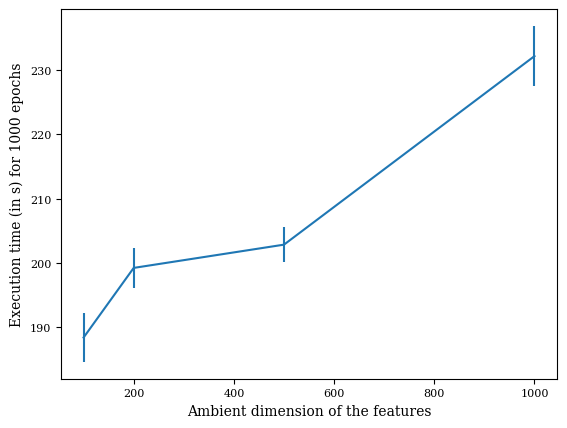

In [11]:
mean_times = [188.4207815647125, 199.2392689704895, 202.85307273864746, 232.152996635437]
std_times = np.array([8.832219184872425, 7.187191816810016, 6.419298745064043, 10.925036758644401])

plt.errorbar([100, 200, 500, 1000], mean_times, 0.96*std_times/np.sqrt(NEXP))
plt.ylabel("Execution time (in s) for 1000 epochs")
plt.xlabel("Ambient dimension of the features")
plt.show()